In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [14]:
data_train = pd.read_csv("data/train.csv")

In [15]:
data_train.drop(["id"], axis=1, inplace=True)

data_train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [6]:
data_train.isna().any().value_counts()

False    17
Name: count, dtype: int64

## EDA on Numeric Features

=== Summary Statistics ===
                 age        balance       duration       campaign  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       40.926395    1204.067397     256.229144       2.577008   
std        10.098829    2836.096759     272.555662       2.718514   
min        18.000000   -8019.000000       1.000000       1.000000   
25%        33.000000       0.000000      91.000000       1.000000   
50%        39.000000     634.000000     133.000000       2.000000   
75%        48.000000    1390.000000     361.000000       3.000000   
max        95.000000   99717.000000    4918.000000      63.000000   

               pdays       previous  
count  750000.000000  750000.000000  
mean       22.412733       0.298545  
std        77.319998       1.335926  
min        -1.000000       0.000000  
25%        -1.000000       0.000000  
50%        -1.000000       0.000000  
75%        -1.000000       0.000000  
max       871.000000     200.000000  


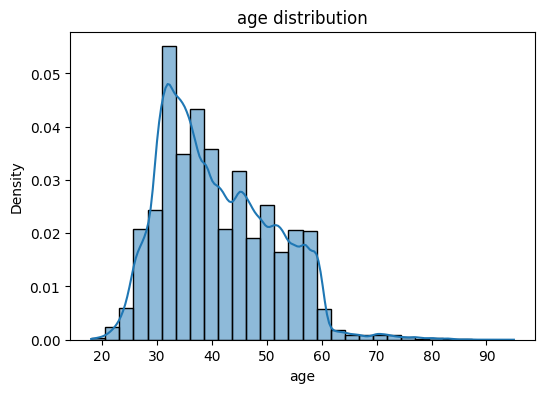

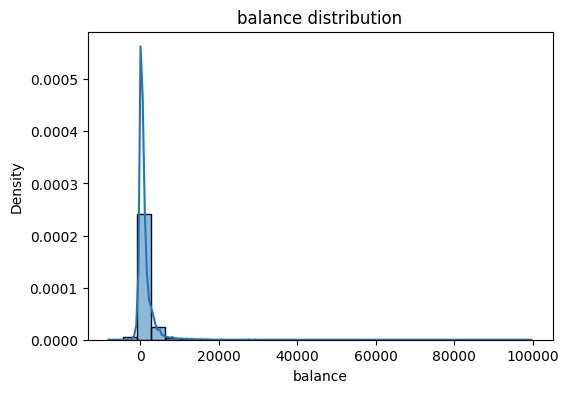

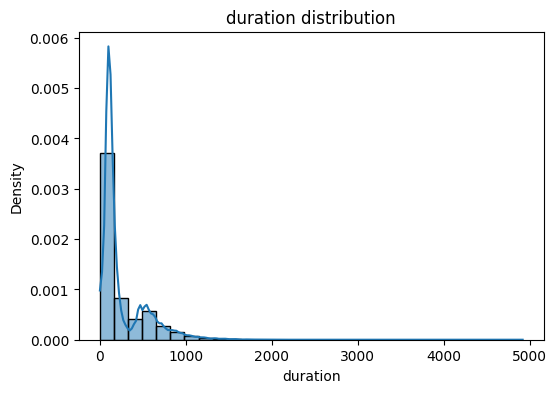

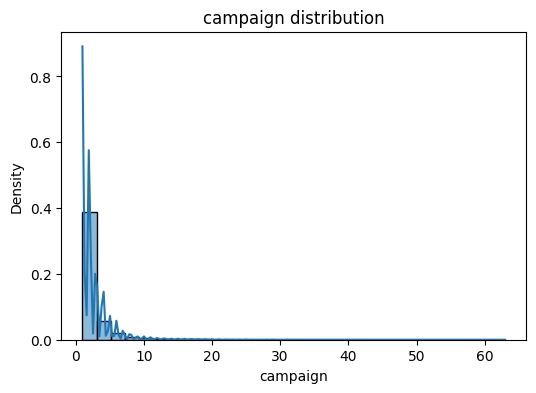

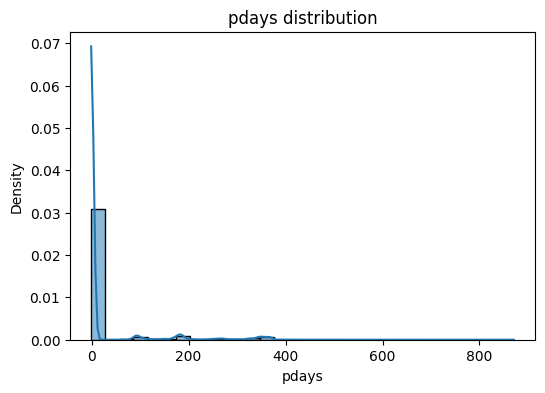

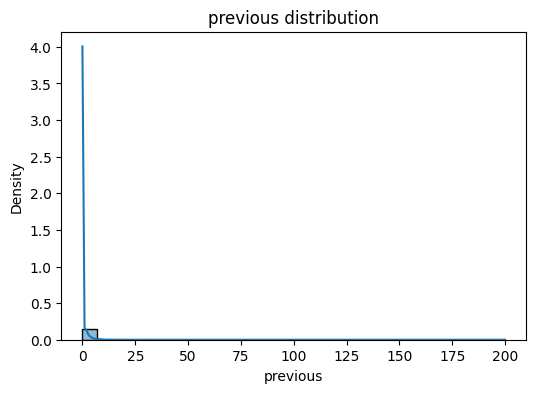


=== Outlier Summary ===
     age:  IQR outliers ~0.7%  |  Z outliers ~0.5%
 balance:  IQR outliers ~7.7%  |  Z outliers ~1.2%
duration:  IQR outliers ~6.1%  |  Z outliers ~1.8%
campaign:  IQR outliers ~5.4%  |  Z outliers ~2.0%
   pdays:  IQR outliers ~10.3%  |  Z outliers ~4.1%
previous:  IQR outliers ~10.3%  |  Z outliers ~1.6%


/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


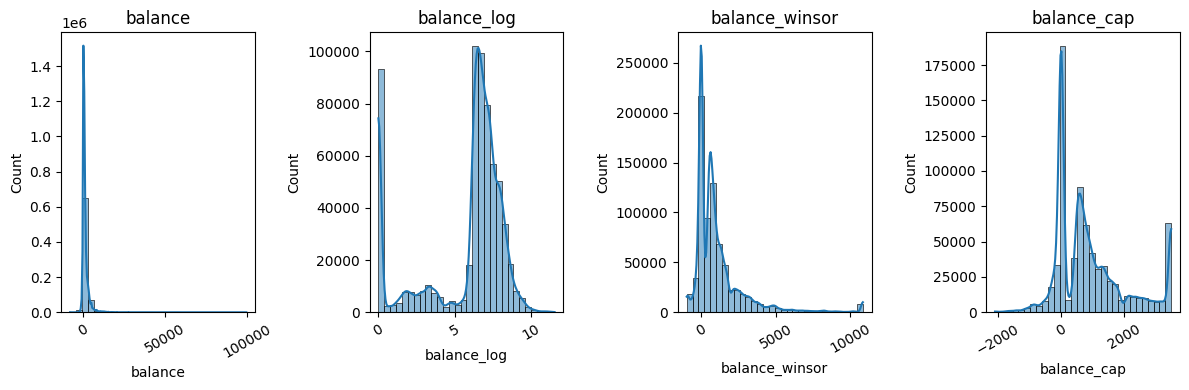

In [16]:

# 1. Specify the numeric columns
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# 2. Summary statistics
print("=== Summary Statistics ===")
print(data_train[num_cols].describe())

# 3. Plot histograms + KDEs
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data_train[col], kde=True, stat="density", bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

# 4. Outlier detection
outlier_info = {}
for col in num_cols:
    Q1 = data_train[col].quantile(0.25)
    Q3 = data_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    mask_iqr = (data_train[col] < lower) | (data_train[col] > upper)
    pct_iqr = mask_iqr.mean() * 100
    
    z_scores = np.abs(stats.zscore(data_train[col].dropna()))
    mask_z = z_scores > 3
    pct_z = mask_z.mean() * 100
    
    outlier_info[col] = {
        'IQR_bounds': (lower, upper),
        '% outside IQR': pct_iqr,
        '% |z|>3': pct_z
    }

print("\n=== Outlier Summary ===")
for col, info in outlier_info.items():
    print(f"{col:>8}:  IQR outliers ~{info['% outside IQR']:.1f}%  |  Z outliers ~{info['% |z|>3']:.1f}%")

# 5. Handling skew / outliers
# Example for 'balance' (repeat as needed for other cols):

# a) Log-transform (for right-skew)
data_train['balance_log'] = np.log1p(data_train['balance'])

# b) Winsorize at the 1st and 99th percentiles
lower_pct, upper_pct = data_train['balance'].quantile([0.01, 0.99])
data_train['balance_winsor'] = data_train['balance'].clip(lower=lower_pct, upper=upper_pct)

# c) Capping using IQR bounds
low, high = outlier_info['balance']['IQR_bounds']
data_train['balance_cap'] = data_train['balance'].clip(lower=low, upper=high)

# Inspect transformations
plt.figure(figsize=(12,4))
for i, col in enumerate(['balance', 'balance_log', 'balance_winsor', 'balance_cap'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(data_train[col], kde=True, bins=30)
    plt.title(col)
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
